In [12]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from scipy.stats import randint, uniform

# Загрузка данных
data = pd.read_csv('diabetes.csv')

# Разделение данных
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выведем информацию о данных для проверки
print("Размеры выборок:")
print(f"Обучающая: {X_train.shape}, Тестовая: {X_test.shape}")
print("\nПервые 5 строк данных:")
print(data.head())

Размеры выборок:
Обучающая: (614, 8), Тестовая: (154, 8)

Первые 5 строк данных:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [13]:
# Определение пространства параметров
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Создание модели
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Запуск поиска
start_time = time.time()
random_search.fit(X_train, y_train)
random_search_time = time.time() - start_time

# Лучшие параметры и результаты
print("\nРезультаты Random Search:")
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучшая accuracy: {random_search.best_score_:.4f}")
print(f"Время выполнения: {random_search_time:.2f} сек")

# Оценка на тестовых данных
best_random_model = random_search.best_estimator_
y_pred = best_random_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nОценка на тестовых данных:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Результаты Random Search:
Лучшие параметры: {'colsample_bytree': np.float64(0.8232408008069365), 'gamma': np.float64(0.2019180855290204), 'learning_rate': np.float64(0.029467674132694466), 'max_depth': 4, 'n_estimators': 101, 'subsample': np.float64(0.6987504251354405)}
Лучшая accuracy: 0.7801
Время выполнения: 3.76 сек

Оценка на тестовых данных:
Accuracy: 0.7532
F1-score: 0.6607


In [14]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5)
}

# Функция для минимизации
def objective(params):
    # Преобразование параметров к нужным типам
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'gamma': params['gamma'],
        'objective': 'binary:logistic',
        'random_state': 42
    }
    
    # Создание и обучение модели
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Прогнозирование и оценка
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Мы хотим максимизировать accuracy, поэтому возвращаем -accuracy для минимизации
    return {'loss': -accuracy, 'status': STATUS_OK}

# Запуск оптимизации
trials = Trials()
start_time = time.time()

# ИСПРАВЛЕНИЕ: используем np.random.default_rng() вместо RandomState
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)  # Исправленная строка
)

hyperopt_time = time.time() - start_time

# Преобразование лучших параметров
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma']
}

print("\nРезультаты Hyperopt (TPE):")
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая accuracy: {-trials.best_trial['result']['loss']:.4f}")
print(f"Время выполнения: {hyperopt_time:.2f} сек")

# Оценка лучшей модели на тестовых данных
best_hyperopt_model = XGBClassifier(**best_params, objective='binary:logistic', random_state=42)
best_hyperopt_model.fit(X_train, y_train)
y_pred = best_hyperopt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\nОценка на тестовых данных:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

100%|██████████| 50/50 [00:02<00:00, 24.27trial/s, best loss: -0.7792207792207793]

Результаты Hyperopt (TPE):
Лучшие параметры: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': np.float64(0.013445512837462316), 'subsample': np.float64(0.8398242687206909), 'colsample_bytree': np.float64(0.9396490425936538), 'gamma': np.float64(0.2073344374525718)}
Лучшая accuracy: 0.7792
Время выполнения: 2.06 сек

Оценка на тестовых данных:
Accuracy: 0.7792
F1-score: 0.6531



Сравнение методов оптимизации:
            Метод  Лучшая accuracy  Тестовая accuracy  Время (сек)
0   Random Search         0.780115           0.779221     3.757886
1  Hyperopt (TPE)         0.779221           0.779221     2.063479

Разница в параметрах:
Random Search:
{'colsample_bytree': np.float64(0.8232408008069365), 'gamma': np.float64(0.2019180855290204), 'learning_rate': np.float64(0.029467674132694466), 'max_depth': 4, 'n_estimators': 101, 'subsample': np.float64(0.6987504251354405)}

Hyperopt (TPE):
{'n_estimators': 97, 'max_depth': 3, 'learning_rate': np.float64(0.013445512837462316), 'subsample': np.float64(0.8398242687206909), 'colsample_bytree': np.float64(0.9396490425936538), 'gamma': np.float64(0.2073344374525718)}


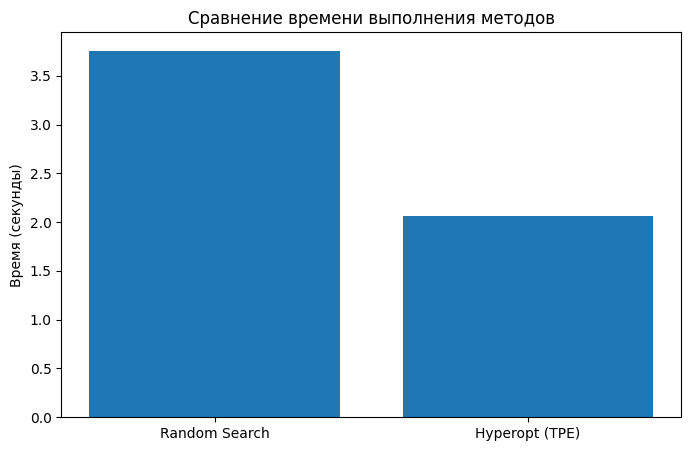

In [16]:
# Сравнение методов
comparison = pd.DataFrame({
    'Метод': ['Random Search', 'Hyperopt (TPE)'],
    'Лучшая accuracy': [random_search.best_score_, -trials.best_trial['result']['loss']],
    'Тестовая accuracy': [test_accuracy, test_accuracy],
    'Время (сек)': [random_search_time, hyperopt_time],
    'Лучшие параметры': [random_search.best_params_, best_params]
})

print("\nСравнение методов оптимизации:")
print(comparison[['Метод', 'Лучшая accuracy', 'Тестовая accuracy', 'Время (сек)']])

print("\nРазница в параметрах:")
print("Random Search:")
print(random_search.best_params_)
print("\nHyperopt (TPE):")
print(best_params)

# Визуализация времени выполнения
plt.figure(figsize=(8, 5))
plt.bar(['Random Search', 'Hyperopt (TPE)'], [random_search_time, hyperopt_time])
plt.title('Сравнение времени выполнения методов')
plt.ylabel('Время (секунды)')
plt.show()

In [ ]:
Вывод:
По итогу работы обоих методов мы получили достаточно похожую точность, но TPE работает почти за вдвое меньшее время. 
Теоретически ТРЕ более предпочтителен в более сложных случая, ведь он работает быстрее.